In [5]:
from bids import BIDSLayout
import os
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'bids'

Create BIDSLayout for original BIDS data

In [ ]:
data_path = "/home/axel/Test2/bids_fmriprep_1subj"
deriv_path = "/home/axel/Test2/bids_fmriprep_1subj/derivatives/fmriprep/"

layout = BIDSLayout(data_path, derivatives=True)
lay=BIDSLayout(data_path)


#all_tables=layout.get(extension='.tsv', suffix='timeseries', scope='derivatives', return_type='filename')
bf = lay.get()


[<BIDSFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/CHANGES'>, <BIDSJSONFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/dataset_description.json'>, <BIDSJSONFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/participants.json'>, <BIDSDataFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/participants.tsv'>, <BIDSFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/README'>, <BIDSJSONFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/scans.json'>, <BIDSJSONFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/sub-pp001/ses-01/anat/sub-pp001_ses-01_inv-1_MP2RAGE.json'>, <BIDSImageFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/sub-pp001/ses-01/anat/sub-pp001_ses-01_inv-1_MP2RAGE.nii.gz'>, <BIDSJSONFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/sub-pp001/ses-01/anat/sub-pp001_ses-01_inv-2_MP2RAGE.json'>, <BIDSImageFile filename='/mnt/extra/data/share/bids_fmriprep_10subj/sub-pp001/ses-01/anat/sub-pp001_ses-01_inv-2_M

In [ ]:
fig = go.Figure()

for i, table in enumerate(all_tables):
    df = pd.read_csv(table, sep='\t')
    if 'global_signal' in df.columns:
        global_signal = df['global_signal']
        fig.add_trace(go.Scatter(y=global_signal, mode='lines', name=str(i+1)))

fig.update_layout(title='Global Signals', 
                  xaxis_title='Time', 
                  yaxis_title='Global Signal', 
                  autosize=True)

fig.show()

This figure is a line graph illustrating the global signals obtained from different files in your data directory. Each line of the graph represents the global signal values extracted from a specific file.

By examining this graph, you can see how the overall signal varies over time for each file, and potentially identify patterns or anomalies.

Let's try and spot the artifacts

In [ ]:
fig = go.Figure()

for i, table in enumerate(all_tables):
    df = pd.read_csv(table, sep='\t')
    if 'global_signal' in df.columns:
        global_signal = df['global_signal']

        # Apply Fast Fourier Transform (FFT)
        fft = np.fft.fft(global_signal)

        # Calculate absolute frequencies
        fft_freq = np.fft.fftfreq(len(global_signal))

        # Plot power spectrum
        fig.add_trace(go.Scatter(x=np.abs(fft_freq), y=np.abs(fft)**2, mode='lines', name='File ' + str(i+1)))

fig.update_layout(title='Power Spectrums', 
                  xaxis_title='Frequency', 
                  yaxis_title='Power', 
                  autosize=True)
#fig.update_yaxes(type="log")


When you zoom in enough, you can see that the maximum frequency is about 0.008. let's round it up to 0.01.

In [ ]:
fig = go.Figure()

table = all_tables[105]

df = pd.read_csv(table, sep='\t')  # You forgot this line

if 'global_signal' in df.columns:
    global_signal = df['global_signal']
    
    # FFT and frequency computation
    fft_vals = np.fft.rfft(global_signal)  # compute FFT
    fft_freq = np.fft.rfftfreq(len(global_signal), d=1.)  # compute frequencies

    # Filter frequencies higher than 0.02
    fft_vals[fft_freq > 0.02] = 0

    # Inverse FFT to get filtered time-domain signal
    filtered_signal = np.fft.irfft(fft_vals)

    # Create a Plotly figure
    fig = go.Figure()

    # Add original and filtered signals to the figure
    fig.add_trace(go.Scatter(y=global_signal, mode='lines', name='Original Signal'))
    fig.add_trace(go.Scatter(y=filtered_signal, mode='lines', name='Filtered Signal'))

    fig.update_layout(title='Global Signal (Original and Filtered)', 
                      xaxis_title='Time', 
                      yaxis_title='Global Signal', 
                      autosize=True)
    fig.show()


Most global signals contain artifacts. Let's try to detect when these artifacts are present.
Here we identify 3 artifacts: at 90, 330 and 510 seconds.
Two things change over very short periods: the amplitude of the wave and its frequency.
We'll try to do an amplitude analysis and then a frequency analysis.

Anomalies:
81     409.470669
86     433.729517
91     430.474289
92     423.062247
94     430.922488
95     436.749682
96     433.037056
97     436.465194
98     434.009230
100    436.986781
326    412.915638
334    436.616971
335    436.294277
336    436.263661
337    436.876457
514    436.248867
515    436.062852
516    436.493955
517    436.464962
Name: global_signal, dtype: float64


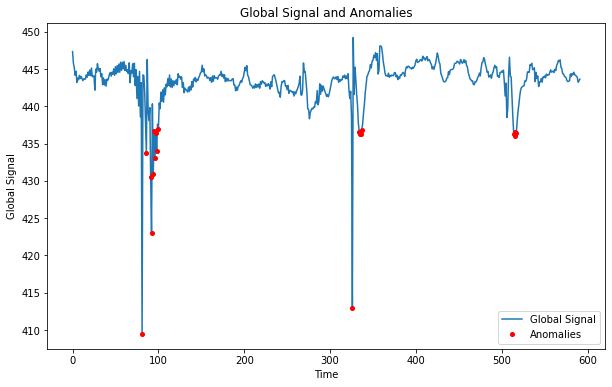

In [ ]:
# Calculate mean and standard deviation
mean_global_signal = np.mean(global_signal)
std_global_signal = np.std(global_signal)

# Define a threshold for anomaly detection (for example, 3 standard deviations from the mean)
threshold = mean_global_signal - 2*std_global_signal

# Identify anomalies
anomalies = global_signal[global_signal < threshold]

# Print the anomalies
print('Anomalies:')
print(anomalies)

# Visualize the data and anomalies
plt.figure(figsize=(10, 6))
plt.plot(global_signal, label='Global Signal')
plt.plot(anomalies, 'ro', markersize=4, label='Anomalies')
plt.legend()
plt.title('Global Signal and Anomalies')
plt.xlabel('Time')
plt.ylabel('Global Signal')
plt.show()


We can also perform a very small-window frequency abalysis of the sprectrogram type. This will give us very good temporal resolution and enable us to visualize areas of very brief frequency changes. 

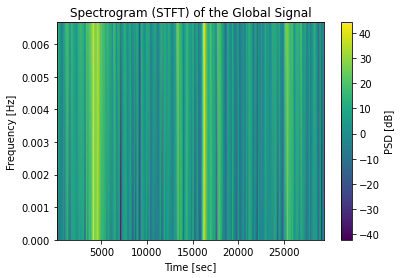

In [ ]:
from scipy.signal import spectrogram

# Assume that 'global_signal' is your signal and 'fs' is the sampling ratefs
fs=0.02
frequencies, times, Sxx = spectrogram(global_signal, fs, nperseg=3)

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='PSD [dB]')
plt.title('Spectrogram (STFT) of the Global Signal')
plt.show()

The windowed frequency analysis reveals 4 bands with higher frequencies.
For greater robustness, we could combine the two methods to find points where the two are strongly correlated.

[ 15.49262801   7.96838956  -1.43389783  -0.37057108  -3.51243968
   4.3065407    0.95477633  10.20319718  15.83726499   5.94919598
  -1.12641161   9.75147908   9.75640078   8.2094014    5.88301774
   4.13299542   8.44477944  11.01082087  10.70226855  10.80264238
  11.28998771  -4.09947295  18.25719949  11.29014395  19.53988537
  19.08228313  25.74869984  39.75886374  27.83880203  26.89946065
  33.77351863  29.24351952  20.66964331  18.97909734  16.53640234
  14.39643036  11.77755213   7.73160362  10.6236373    6.60649815
   3.91480752   1.76639498  10.71911291  12.00980688  -0.06336903
   4.88237373  10.85751509 -16.80260092   0.4186803    5.68036291
   9.27284263   8.1485884   -0.81332082   1.97538706   8.57709809
  -0.87445755  -5.50565255   4.25467503  -6.37826853   8.79557795
   1.05064634 -20.13116641   8.16069203   7.78390759   4.27858915
  -1.14265499   8.57671233   2.12280433   7.91812761  -6.36423897
  -1.21944177   3.53390957   1.25895056   0.61870454  -5.42128253
  -1.24831

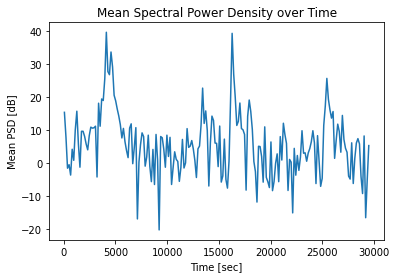

In [ ]:
# Calculate mean PSD for each time point
mean_psd = np.mean(10 * np.log10(Sxx), axis=0)

# Print mean PSD
print(mean_psd)
# Plot mean PSD over time
plt.plot(times, mean_psd)
plt.xlabel('Time [sec]')
plt.ylabel('Mean PSD [dB]')
plt.title('Mean Spectral Power Density over Time')
plt.show()


Anomalies:
[0.58686096 1.         0.64154896 0.61666951 0.81010994 0.67967239]
[0.98898873 0.62149471]
[0.58759723]


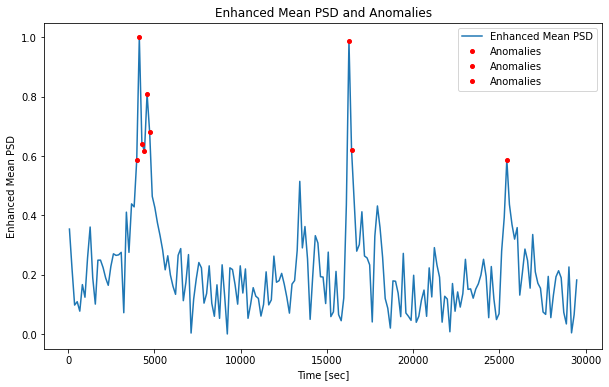

197

In [ ]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

# Your code
normalized_mean_psd = (mean_psd - np.min(mean_psd)) / (np.max(mean_psd) - np.min(mean_psd))
enhanced_mean_psd = normalized_mean_psd ** 2
mean_enhanced_psd = np.mean(enhanced_mean_psd)
std_enhanced_psd = np.std(enhanced_mean_psd)

threshold = mean_enhanced_psd + 2*std_enhanced_psd
anomaly_indices = np.where(enhanced_mean_psd > threshold)[0]

# Group the consecutive indices
grouped_anomaly_indices = group_consecutives(anomaly_indices)

# Print the anomalies
print('Anomalies:')
for group in grouped_anomaly_indices:
    print(enhanced_mean_psd[group])

# Visualize the data and anomalies
plt.figure(figsize=(10, 6))
plt.plot(times, enhanced_mean_psd, label='Enhanced Mean PSD')
for group in grouped_anomaly_indices:
    plt.plot(times[group], enhanced_mean_psd[group], 'ro', markersize=4, label='Anomalies')
plt.legend()
plt.title('Enhanced Mean PSD and Anomalies')
plt.xlabel('Time [sec]')
plt.ylabel('Enhanced Mean PSD')
plt.show()

len(times)






The combination of these two methods enabled us to find artifacts not necessarily visible with amplitude analysis.

In [ ]:
import seaborn as sns

fig = go.Figure()

df = pd.read_csv(table, sep='\t')
if 'global_signal' in df.columns:
    global_signal = df['global_signal']
    
    fs = 0.02
    frequencies, times, Sxx = spectrogram(global_signal, fs, nperseg=3)

    # Calculate mean PSD for each time point
    mean_psd = np.mean(10 * np.log10(Sxx), axis=0)

    # Group the consecutive indices
    grouped_anomaly_indices = group_consecutives(anomaly_indices)

    color_palette = sns.color_palette("hsv", len(grouped_anomaly_indices)).as_hex()

    # Plot the global signal for this file
    fig.add_trace(go.Scatter(y=global_signal, mode='lines', line_color='darkgray', name=f'File {4}'))

    # Plot anomalies on the Plotly figure of the global signal for this file
    for j, group in enumerate(grouped_anomaly_indices):
        start_index = (group[0] * len(global_signal)) // len(times)
        end_index = (group[-1] * len(global_signal)) // len(times)
        start_index = max(min(start_index, len(global_signal)-1), 0)
        end_index = max(min(end_index, len(global_signal)-1), 0)
        anomalies_global = global_signal[start_index:end_index+1]
        time_indices = list(range(start_index, end_index+1))

        if len(group) > 1:
            fig.add_trace(go.Scatter(x=time_indices, y=anomalies_global, mode='lines', line=dict(color=color_palette[j]), name=f'Anomaly {j+1}'))
        else:
            fig.add_trace(go.Scatter(x=time_indices, y=anomalies_global, mode='markers', marker=dict(color=color_palette[j]), name=f'Anomaly {j+1}'))

# Update the layout of the Plotly figure
fig.update_layout(title='Global Signals with Anomalies for File 4', 
                xaxis_title='Time', 
                yaxis_title='Global Signal', 
                autosize=True)

# Show the Plotly figure
fig.show()



In [ ]:
from scipy.signal import spectrogram
from scipy import fftpack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume that 'global_signal' is your signal and 'fs' is the sampling rate
fs = 0.02

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

# List to store filenames of files with anomalies
files_with_anomalies = []

for table in all_tables:
    df = pd.read_csv(table, sep='\t')
    if 'global_signal' in df.columns:
        global_signal = df['global_signal']

        # Calculate spectrogram
        frequencies, times, Sxx = spectrogram(global_signal, fs, nperseg=3)

        # Calculate mean PSD for each time point
        mean_psd = np.mean(10 * np.log10(Sxx), axis=0)

        # Normalized and enhance the mean PSD
        normalized_mean_psd = (mean_psd - np.min(mean_psd)) / (np.max(mean_psd) - np.min(mean_psd))
        enhanced_mean_psd = normalized_mean_psd ** 2
        mean_enhanced_psd = np.mean(enhanced_mean_psd)
        std_enhanced_psd = np.std(enhanced_mean_psd)

        # Calculate threshold and find anomaly indices
        threshold = mean_enhanced_psd + 1*std_enhanced_psd
        anomaly_indices = np.where(enhanced_mean_psd > threshold)[0]

        # Group the consecutive indices
        grouped_anomaly_indices = group_consecutives(anomaly_indices)

        # If any anomalies are found, add the filename to the list
        if len(grouped_anomaly_indices) > 0:
            files_with_anomalies.append(table)

# Print the filenames of the files with anomalies
print("Files with anomalies:")
for filename in files_with_anomalies:
    print(filename)


Files with anomalies:
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/fmriprep/sub-pp001/ses-01/func/sub-pp001_ses-01_task-aliceloc_run-001_desc-confounds_timeseries.tsv
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/fmriprep/sub-pp001/ses-01/func/sub-pp001_ses-01_task-aliceloc_run-002_desc-confounds_timeseries.tsv
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/fmriprep/sub-pp001/ses-01/func/sub-pp001_ses-01_task-aliceloc_run-003_desc-confounds_timeseries.tsv
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/fmriprep/sub-pp001/ses-01/func/sub-pp001_ses-01_task-catloc_run-001_desc-confounds_timeseries.tsv
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/fmriprep/sub-pp001/ses-01/func/sub-pp001_ses-01_task-music_run-001_desc-confounds_timeseries.tsv
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/fmriprep/sub-pp001/ses-01/func/sub-pp001_ses-01_task-music_run-002_desc-confounds_timeseries.tsv
/mnt/extra/data/share/bids_fmriprep_10subj/derivatives/f

In [ ]:
from scipy.signal import spectrogram

all_mean_psd = []  # List to store mean_psd for all files

for i, table in enumerate(all_tables):
    df = pd.read_csv(table, sep='\t')
    if 'global_signal' in df.columns:
        fig = go.Figure()  # Create a new figure for each file

        global_signal = df['global_signal']
        fs = 0.02
        frequencies, times, Sxx = spectrogram(global_signal, fs, nperseg=3)

        # Calculate mean PSD for each time point
        mean_psd = np.mean(10 * np.log10(Sxx), axis=0)
        all_mean_psd.append(mean_psd)

        # Get the number of elements (rows) in the mean_psd array
        num_elements = mean_psd.size

        def group_consecutives(vals, step=1):
            run = []
            result = [run]
            expect = None
            for v in vals:
                if (v == expect) or (expect is None):
                    run.append(v)
                else:
                    run = [v]
                    result.append(run)
                expect = v + step
            return result

        # Your code
        normalized_mean_psd = (mean_psd - np.min(mean_psd)) / (np.max(mean_psd) - np.min(mean_psd))
        enhanced_mean_psd = normalized_mean_psd ** 2
        mean_enhanced_psd = np.mean(enhanced_mean_psd)
        std_enhanced_psd = np.std(enhanced_mean_psd)

        threshold = mean_enhanced_psd + 1*std_enhanced_psd
        anomaly_indices = np.where(enhanced_mean_psd > threshold)[0]

        # Group the consecutive indices
        grouped_anomaly_indices = group_consecutives(anomaly_indices)

        color_palette = sns.color_palette("hsv", len(grouped_anomaly_indices)).as_hex()

        # Plot the global signal for this file
        fig.add_trace(go.Scatter(y=global_signal, mode='lines', line_color='darkgray', name=f'File {i+1}'))

        # Plot anomalies on the Plotly figure of the global signal for this file
        for j, group in enumerate(grouped_anomaly_indices):
            start_index = (group[0] * len(global_signal)) // len(times)
            end_index = (group[-1] * len(global_signal)) // len(times)
            start_index = max(min(start_index, len(global_signal)-1), 0)
            end_index = max(min(end_index, len(global_signal)-1), 0)
            anomalies_global = global_signal[start_index:end_index+1]
            time_indices = list(range(start_index, end_index+1))

            if len(group) > 1:
                fig.add_trace(go.Scatter(x=time_indices, y=anomalies_global, mode='lines', line=dict(color=color_palette[j]), name=f'Anomaly {j+1}'))
            else:
                fig.add_trace(go.Scatter(x=time_indices, y=anomalies_global, mode='markers', marker=dict(color=color_palette[j]), name=f'Anomaly {j+1}'))

        # Update the layout of the Plotly figure
        fig.update_layout(title='Global Signals with Anomalies', 
                        xaxis_title='Time', 
                        yaxis_title='Global Signal', 
                        autosize=True)

        # Show the Plotly figure
        fig.show()

